* Load Dataset

In [1]:
import opendatasets as od
data = od.download("https://www.kaggle.com/competitions/neurips-open-polymer-prediction-2025/data")

Skipping, found downloaded files in ".\neurips-open-polymer-prediction-2025" (use force=True to force download)


* Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


In [2]:
train = pd.read_csv('neurips-open-polymer-prediction-2025/train.csv')
test = pd.read_csv('neurips-open-polymer-prediction-2025/test.csv')
train

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN


In [3]:
train['SMILES'][0]

'*CC(*)c1ccccc1C(=O)OCCCCCC'

* Exploring datasets

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7973 non-null   int64  
 1   SMILES   7973 non-null   object 
 2   Tg       511 non-null    float64
 3   FFV      7030 non-null   float64
 4   Tc       737 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 436.2+ KB


In [6]:
train.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [7]:
train['Tg']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
7968           NaN
7969           NaN
7970           NaN
7971    261.662355
7972           NaN
Name: Tg, Length: 7973, dtype: float64

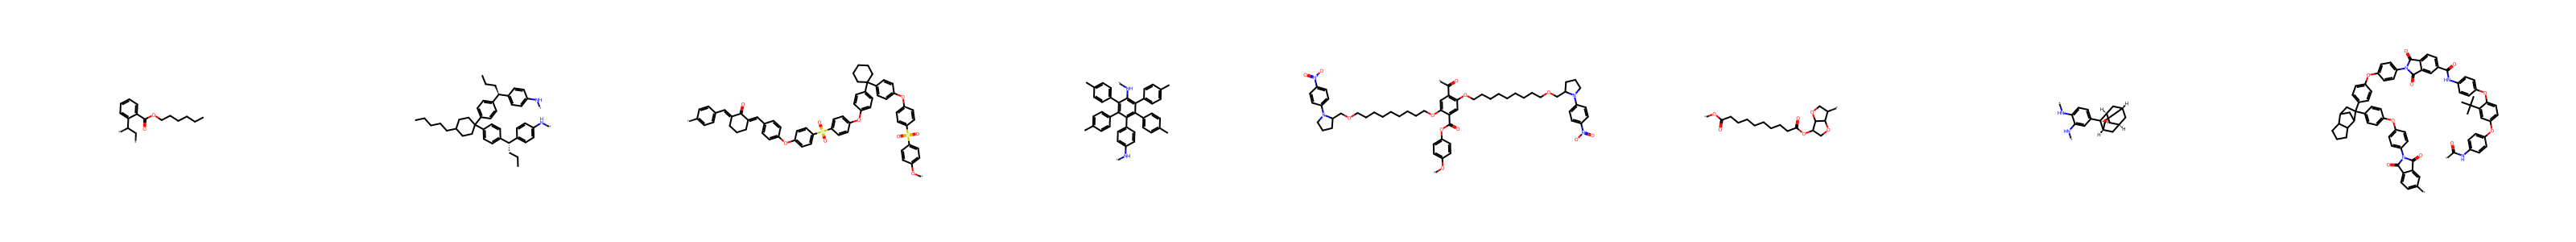

In [10]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in train['SMILES'][0:8]], molsPerRow=8, subImgSize=(400,300))

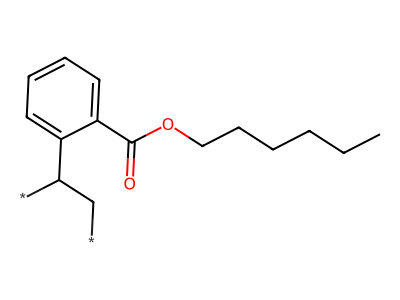

In [11]:
mol = Chem.MolFromSmiles(train['SMILES'][0])
img = Draw.MolsToImage([mol] , subImgSize=(400, 300))
img

In [32]:
train['smiles_len'] = train['SMILES'].str.len()
test ['smiles_len'] = test ['SMILES'].str.len()
features = ['smiles_len']
target_cols = ['Tg','FFV','Tc','Density','Rg']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
test_preds = pd.DataFrame({'id': test['id']})
oof_preds  = pd.DataFrame(index=train.index, columns=target_cols)

In [34]:
for target in target_cols:
    print(f'\n==> Training for target: {target}')
    # 1) only keep rows where this target exists
    mask    = train[target].notnull()
    X_full  = train.loc[mask, features]
    y_full  = train.loc[mask, target].astype(float)

    fold_rmses = []
    test_fold_preds = np.zeros(len(test))

    for fold, (tr_idx, vl_idx) in enumerate(kf.split(X_full), 1):
        X_tr, y_tr = X_full.iloc[tr_idx], y_full.iloc[tr_idx]
        X_vl, y_vl = X_full.iloc[vl_idx], y_full.iloc[vl_idx]

        lgb_tr = lgb.Dataset(X_tr, y_tr)
        lgb_vl = lgb.Dataset(X_vl, y_vl, reference=lgb_tr)

        params = {
            'objective':     'regression',
            'metric':        'rmse',
            'boosting_type': 'gbdt',
            'verbosity':     -1,
            'seed':          42,
        }

        model = lgb.train(
            params,
            lgb_tr,
            num_boost_round=1000,
            valid_sets=[lgb_tr, lgb_vl],
        )

        # predict & score
        vl_pred = model.predict(X_vl, num_iteration=model.best_iteration)
        rmse    = np.sqrt(mean_squared_error(y_vl, vl_pred))
        fold_rmses.append(rmse)
        print(f'  Fold {fold} RMSE: {rmse:.4f}')

        # store OOF -- map back to original train index
        orig_idx = y_vl.index
        oof_preds.loc[orig_idx, target] = vl_pred

        # accumulate test predictions
        test_fold_preds += model.predict(test[features], num_iteration=model.best_iteration) / kf.n_splits

    test_preds[target] = test_fold_preds
    print(f'  >>> Avg RMSE for {target}: {np.mean(fold_rmses):.4f}')

# overall OOF
oof_rmse = np.sqrt(
    ((train[target_cols] - oof_preds[target_cols].astype(float))**2).mean().mean()
)
print(f'\nOverall OOF RMSE: {oof_rmse:.4f}')

# write submission
submission = test_preds[['id'] + target_cols]
submission.to_csv('submission.csv', index=False)
print(submission.head())


==> Training for target: Tg
  Fold 1 RMSE: 95.0806
  Fold 2 RMSE: 121.0980
  Fold 3 RMSE: 123.5325
  Fold 4 RMSE: 99.9194
  Fold 5 RMSE: 105.5126
  >>> Avg RMSE for Tg: 109.0286

==> Training for target: FFV
  Fold 1 RMSE: 0.0316
  Fold 2 RMSE: 0.0285
  Fold 3 RMSE: 0.0277
  Fold 4 RMSE: 0.0282
  Fold 5 RMSE: 0.0298
  >>> Avg RMSE for FFV: 0.0292

==> Training for target: Tc
  Fold 1 RMSE: 0.0842
  Fold 2 RMSE: 0.0864
  Fold 3 RMSE: 0.0858
  Fold 4 RMSE: 0.0756
  Fold 5 RMSE: 0.0823
  >>> Avg RMSE for Tc: 0.0829

==> Training for target: Density
  Fold 1 RMSE: 0.1473
  Fold 2 RMSE: 0.1889
  Fold 3 RMSE: 0.1445
  Fold 4 RMSE: 0.1269
  Fold 5 RMSE: 0.1436
  >>> Avg RMSE for Density: 0.1502

==> Training for target: Rg
  Fold 1 RMSE: 4.6088
  Fold 2 RMSE: 4.5291
  Fold 3 RMSE: 4.4381
  Fold 4 RMSE: 4.4951
  Fold 5 RMSE: 4.4679
  >>> Avg RMSE for Rg: 4.5078

Overall OOF RMSE: 49.0529
           id          Tg       FFV        Tc   Density         Rg
0  1109053969  116.950098  0.369034  0.